# Project summary

### Introduction
Scope of the project is to create a Neural Network architecture which is able to generate captions for images. The final architecture is a combination of CNN architecture for processing images with LSTM layer for representing image data as well es Dense and regularization layers.

### Dataset
The dataset used for image captioning is Flickr8k dataset which is a subset of Flickr30k - commonly used dataset in research papaers about image processing. Dataset was downloaded from https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip. The .zip file includes the following files:
- `Flicker8k_Dataset` folder with 8000 images
- `Flickr8k_text` folder with text data, including among others: 
    - `Flickr_8k.trainImages.txt` with names of 6k images used as training set  
    - `Flickr_8k.testImages.txt` with 1k names of images used as test set
    - `Flickr8k.token.txt` with captions for each image (5 different captions per each image)

In this project, the dataset was split into train and test dataset exactly based on the provided .txt files.
More information about the datasets can be found here:
- https://paperswithcode.com/dataset/flickr30k
- https://paperswithcode.com/dataset/flickr-8k

Final dataset that was fed into the network is in the following form:

| Input image                                                        | Input text                                  | Target text |
|--------------------------------------------------------------------|---------------------------------------------|-------------|
| Preprocessed image from 'Flicker8k_Dataset/2513260012_03d33305cf.jpg' | [START]                                     | two         |
| Preprocessed image from 'Flicker8k_Dataset/2513260012_03d33305cf.jpg' | [START] two                                 | dogs        |
| Preprocessed image from 'Flicker8k_Dataset/2513260012_03d33305cf.jpg' | [START] two dogs                            | play        |
| Preprocessed image from 'Flicker8k_Dataset/2513260012_03d33305cf.jpg' | [START] two dogs play                       | together    |
| Preprocessed image from 'Flicker8k_Dataset/2513260012_03d33305cf.jpg' | [START] two dogs play together              | in          |
| Preprocessed image from 'Flicker8k_Dataset/2513260012_03d33305cf.jpg' | [START] two dogs play together in           | the         |
| Preprocessed image from 'Flicker8k_Dataset/2513260012_03d33305cf.jpg' | [START] two dogs play together in the       | snow        |
| Preprocessed image from 'Flicker8k_Dataset/2513260012_03d33305cf.jpg' | [START] two dogs play together in the snow  | [END]       |

Additionally, the text data (`Input text` and `Target text` columns) is tokenized and padded. More detailed information in further sections of the project.

### Model
#### Architecture
The starting point for building the model was based on 2 sources:
- https://arxiv.org/pdf/1708.02043v2.pdf (merge architecture)
- https://www.hackersrealm.net/post/image-caption-generator-using-python

On top of that, inspired by https://www.tensorflow.org/tutorials/text/image_captioning and MobileNet for feature extraction, I added a `Functional` layer for image pre-processing which is the Densenet201 model architecture to extract features from the images. It was done with https://www.tensorflow.org/api_docs/python/tf/keras/applications/densenet/DenseNet201 with pre-trained weights.
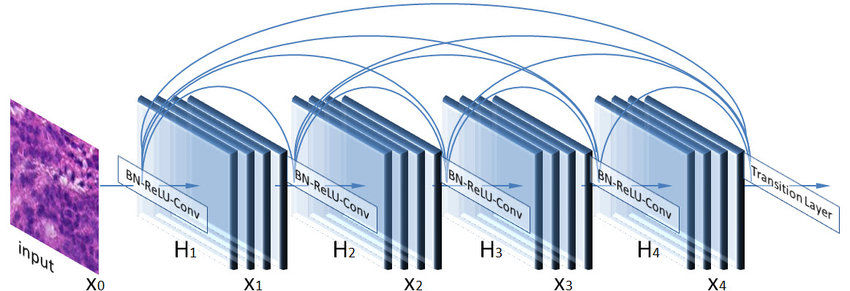

Then I assessed the results and adjusted the model architecture 4 times:
1. Model 2: Deleted `Dropout` layers in original model to analyze overfitting
2. Model 3: Added `BatchNormalization` layers in original model to balance weights responsible for image and text representation.
3. Model 4: Replaced `add` layer with `Concatenate` layer in Model 3 to separately represent text and image data.
4. Increased batch size from 32 to 64 in Model 4.

The final architecture selected for this task is presented on a picture below:
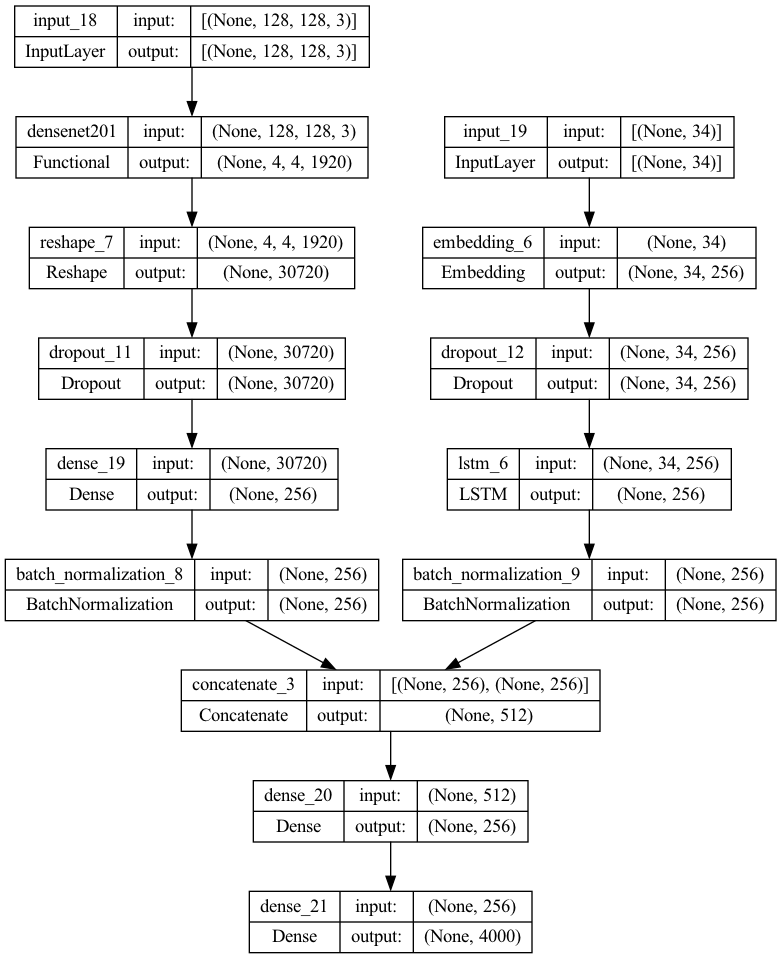


#### Hyperparameters
- Optimizer: Adam optimizer
- Loss function: Categorical cross-entropy
- Dropout rate for `Dropout` layers: 0.4
- Dictionary size: 4000
- Epoch: 1
- Batch size: 32 (64 for 5th attempt)

This project does not include hyperparameter tuning because the whole training dataset is 60GB and it takes 2.5 hours to train the network with only one epoch.

#### Model assessment
The assessment and final choice of model architecture is made based on:
- Subjective assessment on whether generated captions make are correct
- Value of the loss function on test and train dataset after one epoch of training

The model assessment can be improved and should be conducted in more quantitative manner, but requires higher computational power. It could be done in the future in the following way:
- Analysis of the Bleu Score
- Training on higher number of epochs and analysis of loss value for test and train datasets

Based on this, the architecture can be further improved and hyperparameters can be tuned.

### Summary
The project covers creating a neural network architecture for image captioning. The results are satisfactory, but further work is required (mainly quantitative analysis of results) to improve the reasoning methodology.

### Bibliography
- https://arxiv.org/pdf/1810.00736.pdf
- https://arxiv.org/pdf/1810.04020.pdf
- https://paperswithcode.com/task/image-captioning
- https://www.tensorflow.org/api_docs/python/tf/keras/

### External code sources
- https://www.tensorflow.org/tutorials/text/image_captioning
- https://towardsdatascience.com/image-captions-with-attention-in-tensorflow-step-by-step-927dad3569fa
- https://www.hackersrealm.net/post/image-caption-generator-using-python

### Improvement and further work ideas
- Assessment with BLEU score
- Training on more epochs with more computing power and quantitative analysis of overfitting and bias
- Introducing attention mechanism to the model (as it is used in many papers)
- Some code is repeating and could be extracted into functions

# Project content

## Preparations

I'll load required packages and variables at the beginning

In [11]:
import tensorflow as tf
import pathlib
import collections
from matplotlib import image
from matplotlib import pyplot
import re
import numpy as np
IMAGE_SHAPE = (128,128,3)

## Preparing datasets

### Pre-processing of captions

Then, I'll prepare tensorflow Dataset based on the tutorial at https://www.tensorflow.org/tutorials/text/image_captioning.  

The Flickr8k dataset can be downloaded here: https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip and saved into the directory where the jupyter notebook is located.

In [21]:
#splitting the captions into {'Path': ['Caption1', 'Caption2']} etc
path = pathlib.Path("Flickr8k_text")
captions = (path/"Flickr8k.token.txt").read_text().splitlines()
captions = (line.split('\t') for line in captions)
captions = ((fname.split('#')[0], caption) for (fname, caption) in captions)
cap_dict = collections.defaultdict(list)
for fname, cap in captions:
    cap_dict[fname].append(cap)

In [22]:
#view captions
cap_dict = dict(cap_dict)

I will also clean up the captions

In [23]:
#define function
def captions_clean(image_dict):
    d = {}
    for key, captions in image_dict.items():
        for i, caption in enumerate (captions):
            caption_nopunct = re.sub(r"[^a-zA-Z0-9]+", ' ', caption.lower())
            clean_words = [word for word in caption_nopunct.split() if ((len(word) > 1) and (word.isalpha()))]
            caption_new = ' '.join(clean_words)
            caption_new = '[START] ' + caption_new + ' [END]'
            captions[i] = caption_new
        d[key] = captions
    return d

#check how the function works
clean_cap_dict = captions_clean(cap_dict)

In [24]:
photo_path = pathlib.Path("Flicker8k_Dataset")

train_files = (path/'Flickr_8k.trainImages.txt').read_text().splitlines()
train_captions = [(str(photo_path/fname), clean_cap_dict[fname]) for fname in train_files]

test_files = (path/'Flickr_8k.testImages.txt').read_text().splitlines()
test_captions = [(str(photo_path/fname), clean_cap_dict[fname]) for fname in test_files]

In [25]:
train_captions[0:2]

[('Flicker8k_Dataset/2513260012_03d33305cf.jpg',
  ['[START] black dog is running after white dog in the snow [END]',
   '[START] black dog chasing brown dog through snow [END]',
   '[START] two dogs chase each other across the snowy ground [END]',
   '[START] two dogs play together in the snow [END]',
   '[START] two dogs running through low lying body of water [END]']),
 ('Flicker8k_Dataset/2903617548_d3e38d7f88.jpg',
  ['[START] little baby plays croquet [END]',
   '[START] little girl plays croquet next to truck [END]',
   '[START] the child is playing croquette by the truck [END]',
   '[START] the kid is in front of car with put and ball [END]',
   '[START] the little boy is playing with croquet hammer and ball beside the car [END]'])]

### Creating tokenizer

I splitted datasets into test and train sets. Now I'll create tf `Dataset` object `train_ds`, from which later the tokenizer will be created.

In [26]:
train_ds = tf.data.experimental.from_list(train_captions)

Now I will create dictionary of vocabs.

In [27]:
vocabulary_size = 4000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=None,
    ragged=True)

In [28]:
tokenizer.adapt(train_ds.map(lambda fp,txt: txt).unbatch().batch(1024))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

In [29]:
#check last words on a vocab list -whether make sense
tokenizer.get_vocabulary()[-10:]

['jumpsuits',
 'jug',
 'judges',
 'judge',
 'jr',
 'jousting',
 'join',
 'italy',
 'ipod',
 'involved']

I am also creating a function to transform tokens back to text.

In [30]:
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

### Image pre-processing

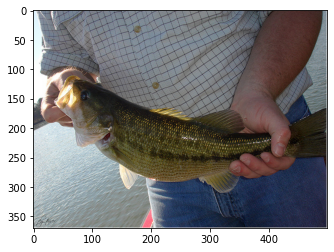

In [16]:
#load examplary image
image2 = image.imread('Flicker8k_Dataset/143237785_93f81b3201.jpg')
pyplot.imshow(image2)
pyplot.show()

In [18]:
#check image resolution
image2.shape

(370, 500, 3)

The pictures need to be resized when loading. I am also aplying pre-processing to extract features (`tf.keras.applications.densenet.preprocess_input(img)`) because this is required in Keras if I want to later process the images with Densenet architecture.

Related documentation: https://www.tensorflow.org/api_docs/python/tf/keras/applications/densenet/DenseNet201.

In [7]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32)
    img = tf.image.resize(img, IMAGE_SHAPE[:-1])
    img = tf.keras.applications.densenet.preprocess_input(img)
    return img, image_path

### Preparing for generating ready train and test datasets

Right now the set is in the form:
```
[
('imagepath1', ['caption1', 'caption2']),  
('imagepath2', ['caption1', 'caption2'])
]
```

And I want to have a set tensorflow `Dataset` object `[((image1, input_text1), pred_word1), ((image2, input_text2), pred_word2)]`

In [35]:
train_captions[0:2]

[('Flicker8k_Dataset/2513260012_03d33305cf.jpg',
  ['[START] black dog is running after white dog in the snow [END]',
   '[START] black dog chasing brown dog through snow [END]',
   '[START] two dogs chase each other across the snowy ground [END]',
   '[START] two dogs play together in the snow [END]',
   '[START] two dogs running through low lying body of water [END]']),
 ('Flicker8k_Dataset/2903617548_d3e38d7f88.jpg',
  ['[START] little baby plays croquet [END]',
   '[START] little girl plays croquet next to truck [END]',
   '[START] the child is playing croquette by the truck [END]',
   '[START] the kid is in front of car with put and ball [END]',
   '[START] the little boy is playing with croquet hammer and ball beside the car [END]'])]

The function `data_prep` below does the following:
1. It takes an array `[('imagepath1', ['caption1', 'caption2']), ('imagepath2', ['caption1', 'caption2'])]` similar to `train_captions` and a tokenizer as an argument.
2. It loads each image and splits the captions into input sequence and target word, also adds the padding and tokenizes.
3. For each image, it returns the following pre-processed data: 

| Input image                                                        | Input text                                  | Target text |
|--------------------------------------------------------------------|---------------------------------------------|-------------|
| Preprocessed image from 'Flicker8k_Dataset/2513260012_03d33305cf.jpg' | [START]                                     | two         |
| Preprocessed image from 'Flicker8k_Dataset/2513260012_03d33305cf.jpg' | [START] two                                 | dogs        |
| Preprocessed image from 'Flicker8k_Dataset/2513260012_03d33305cf.jpg' | [START] two dogs                            | play        |
| Preprocessed image from 'Flicker8k_Dataset/2513260012_03d33305cf.jpg' | [START] two dogs play                       | together    |
| Preprocessed image from 'Flicker8k_Dataset/2513260012_03d33305cf.jpg' | [START] two dogs play together              | in          |
| Preprocessed image from 'Flicker8k_Dataset/2513260012_03d33305cf.jpg' | [START] two dogs play together in           | the         |
| Preprocessed image from 'Flicker8k_Dataset/2513260012_03d33305cf.jpg' | [START] two dogs play together in the       | snow        |
| Preprocessed image from 'Flicker8k_Dataset/2513260012_03d33305cf.jpg' | [START] two dogs play together in the snow  | [END]       |


Additionally, the data `input_text` is tokenized and padded with 0s at the end and `target_text` is tokenized. At the end, the result may look like this:

| Input image                                                        | Input text           | Target text |
|--------------------------------------------------------------------|----------------------|-------------|
| Preprocessed image from 'Flicker8k_Dataset/2513260012_03d33305cf.jpg' | [2,0,0,...,0]        | 65          |
| Preprocessed image from 'Flicker8k_Dataset/2513260012_03d33305cf.jpg' | [2,65,0,...,0]       | 123         |
| Preprocessed image from 'Flicker8k_Dataset/2513260012_03d33305cf.jpg' | [2,65,123,...,0]     | 678         |
| Preprocessed image from 'Flicker8k_Dataset/2513260012_03d33305cf.jpg' | ...                  | ...         |
| Preprocessed image from 'Flicker8k_Dataset/2513260012_03d33305cf.jpg' | [2,65,123,...,678] | 3           |

Where 2 represents `[START]` and 3 represents `[END]`.

In [18]:
def data_prep(data_list, tokenizer):
    img_paths, X = list(), list()
    input_text_temp, input_text_res = list(), list()
    pred_label_temp, pred_label_res = list(), list()

    for element in data_list:
        img_path, captions = element
        image, image_path = load_image(img_path)
        for caption in captions:
            word_idxs = tokenizer(caption)
            for j in range(1, len(word_idxs)):
                input_text = word_idxs[:j]
                pred_label = word_idxs[j]
                pred_label = tf.keras.utils.to_categorical(pred_label, num_classes=vocabulary_size)
                input_text_temp.append(input_text)
                pred_label_temp.append(pred_label)
                X.append(image)
                img_paths.append(image_path)
    
    input_text_temp = tf.keras.utils.pad_sequences(input_text_temp, maxlen = 34, padding = 'post')
    
    for i in range(len(input_text_temp)):
        input_text_res.append(tf.convert_to_tensor(input_text_temp[i]))
        pred_label_res.append(tf.convert_to_tensor(pred_label_temp[i]))
        
    
    return img_paths, X, input_text_res, pred_label_res

### Generating and saving train dataset

In [100]:
img_paths, images, input_texts, pred_labels = data_prep(train_captions, tokenizer)

In [101]:
train_dataset = tf.data.Dataset.from_tensor_slices(((images, input_texts), pred_labels))

In [22]:
print("Number of elements in train dataset: ", len(list(train_dataset)))

Number of elements in train dataset:  307074


Checking if the tensor shapes are correct

In [98]:
train_dataset.element_spec

((TensorSpec(shape=(None, None, 128, 128, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None, 34), dtype=tf.int32, name=None)),
 TensorSpec(shape=(None, None, 4000), dtype=tf.float32, name=None))

Everything works fine, so I will now save the dataset and load it so I do not have to do it all again next time.

In [ ]:
tf.data.Dataset.save(train_dataset, '/Users/marcinzurek/Desktop/Aproksymacja/Projekt/train_dataset')

In [8]:
train_dataset = tf.data.Dataset.load('/Users/marcinzurek/Desktop/Aproksymacja/Projekt/train_dataset')

### Generating and saving test dataset

In [19]:
test_img_paths, test_images, test_input_texts, test_pred_labels = data_prep(test_captions, tokenizer)
test_dataset = tf.data.Dataset.from_tensor_slices(((test_images, test_input_texts), test_pred_labels))

In [24]:
print("Number of elements in test dataset: ", len(list(test_dataset)))

Number of elements in test dataset:  51393


In [28]:
tf.data.Dataset.save(test_dataset, '/Users/marcinzurek/Desktop/Aproksymacja/Projekt/test_dataset')

In [9]:
test_dataset = tf.data.Dataset.load('/Users/marcinzurek/Desktop/Aproksymacja/Projekt/test_dataset')

### Confirmation that everything looks correct

Now lets check an example if everything works fine. I will select the 9th picture from the train dataset.

In [40]:
test_img_paths[10]

'Flicker8k_Dataset/3385593926_d3e9c21170.jpg'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Original')

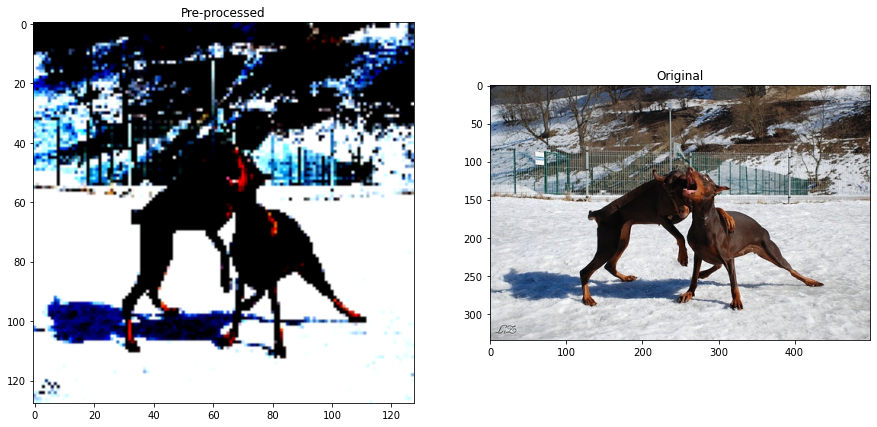

In [39]:
img = test_images[10]
fig, (ax1,ax2) = pyplot.subplots(nrows=1,ncols=2,figsize=(15,10))
ax1.imshow(img)
ax1.set_title("Pre-processed")
original = image.imread(test_img_paths[10])
pyplot.imshow(original)
ax2.set_title("Original")

In [37]:
print("Input caption: ", index_to_word(test_input_texts[10]))
print("Target label: ", index_to_word(np.argmax(test_pred_labels[10])))

Input caption:  tf.Tensor(
[b'[START]' b'the' b'dogs' b'are' b'in' b'the' b'snow' b'in' b'front'
 b'of' b'fence' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b''
 b'' b'' b'' b'' b'' b'' b'' b'' b''], shape=(34,), dtype=string)
Target label:  tf.Tensor(b'[END]', shape=(), dtype=string)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Input caption:  tf.Tensor(
[b'[START]' b'woman' b'wearing' b'black' b'coat' b'and' b'sunglasses'
 b'is' b'standing' b'in' b'front' b'of' b'man' b'walking' b'away' b'with'
 b'backpack' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b''
 b'' b''], shape=(34,), dtype=string)
Target label:  tf.Tensor(b'[END]', shape=(), dtype=string)


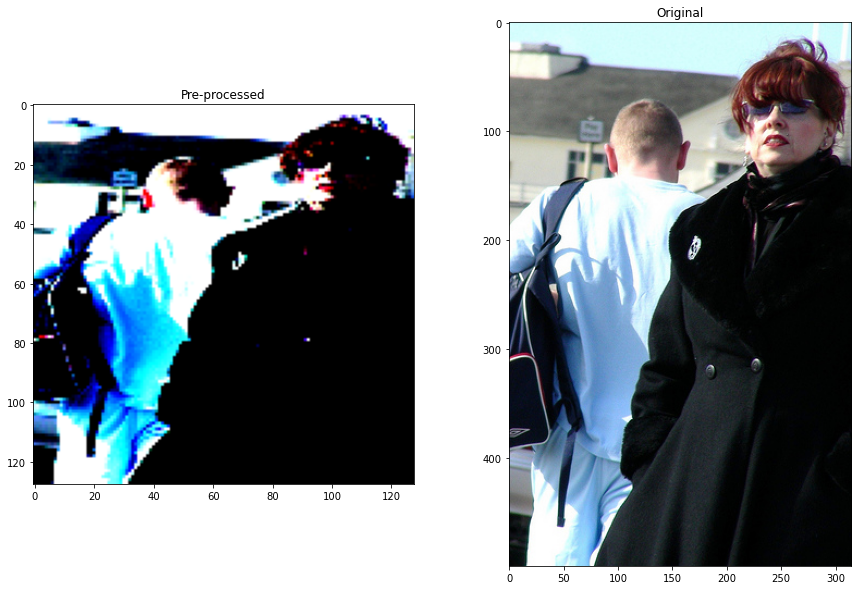

In [241]:
img = test_images[1598]
fig, (ax1,ax2) = pyplot.subplots(nrows=1,ncols=2,figsize=(15,10))
ax1.imshow(img)
ax1.set_title("Pre-processed")
original = image.imread(test_img_paths[1598])
pyplot.imshow(original)
ax2.set_title("Original")
print("Input caption: ", index_to_word(test_input_texts[1598]))
print("Target label: ", index_to_word(np.argmax(test_pred_labels[1598])))

## Neural network

The dataset is ready for training and testing. Time to create a network.

### Densenet layer for pictures pre-processing

The images will be preprocessed using a CNN architecture. I selected densenet201 architecture - here is why:
- tensorflow tutorial uses MobileNetV3Small: https://www.tensorflow.org/tutorials/text/image_captioning 
- there is a tutorial which uses InceptionV3: https://towardsdatascience.com/image-captions-with-attention-in-tensorflow-step-by-step-927dad3569fa
- based on https://arxiv.org/pdf/1810.00736.pdf the Densenet201 has similar performance and lower computational complexity than the other 2 mentioned above architectures

Documentations: https://www.tensorflow.org/api_docs/python/tf/keras/applications/densenet/DenseNet201

I'll load wegights pre-trained on imagenet and sat them to non-trainable.

In [5]:
image_model = tf.keras.applications.DenseNet201(include_top=False, 
                                                weights='imagenet',
                                               input_shape = IMAGE_SHAPE)
image_model.trainable = False

I'll check if there is no error when trying to preprocess one photo and what are the dimentions of input and output.

In [6]:
print("Input shape: \n", image_model.input, "\n")
print("Output shape: \n", image_model.layers[-1].output, "\n")
img_feature_extraction = tf.keras.Model(image_model.input, image_model.layers[-1].output)

Input shape: 
 KerasTensor(type_spec=TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='input_3'), name='input_3', description="created by layer 'input_3'") 

Output shape: 
 KerasTensor(type_spec=TensorSpec(shape=(None, 4, 4, 1920), dtype=tf.float32, name=None), name='relu/Relu:0', description="created by layer 'relu'") 



In [11]:
img, image_path = load_image('Flicker8k_Dataset/143237785_93f81b3201.jpg')
img = tf.expand_dims(img, axis=0)
print("Input shape: ", img.shape)
output = img_feature_extraction(img)
print("Output shape: ", output.shape,)

Input shape:  (1, 128, 128, 3)
Output shape:  (1, 4, 4, 1920)


### Defining callbacks to assess the learning

In [29]:
#based on https://faroit.com/keras-docs/0.3.3/callbacks/
#based on https://keras.io/guides/writing_your_own_callbacks/#a-basic-example

class LossHistory(tf.keras.callbacks.Callback):
    def on_test_begin(self, logs={}):
        self.test_losses = []
        print("Evaluation started.")

    def on_test_batch_end(self, batch, logs={}):
        self.test_losses.append(logs.get('loss'))
        
    def on_train_begin(self, logs={}):
        self.train_losses = []
        print("Training started.")
        
    def on_train_batch_end(self, batch, logs={}):
        self.train_losses.append(logs.get('loss'))

history = LossHistory()

### 1st approach to generating the architecture - default approach

Using similar approach to the one described as "merge architecture" in https://arxiv.org/pdf/1708.02043v2.pdf.
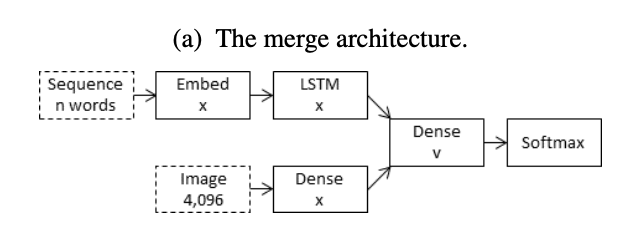
Code partially borrowed from: https://www.hackersrealm.net/post/image-caption-generator-using-python.

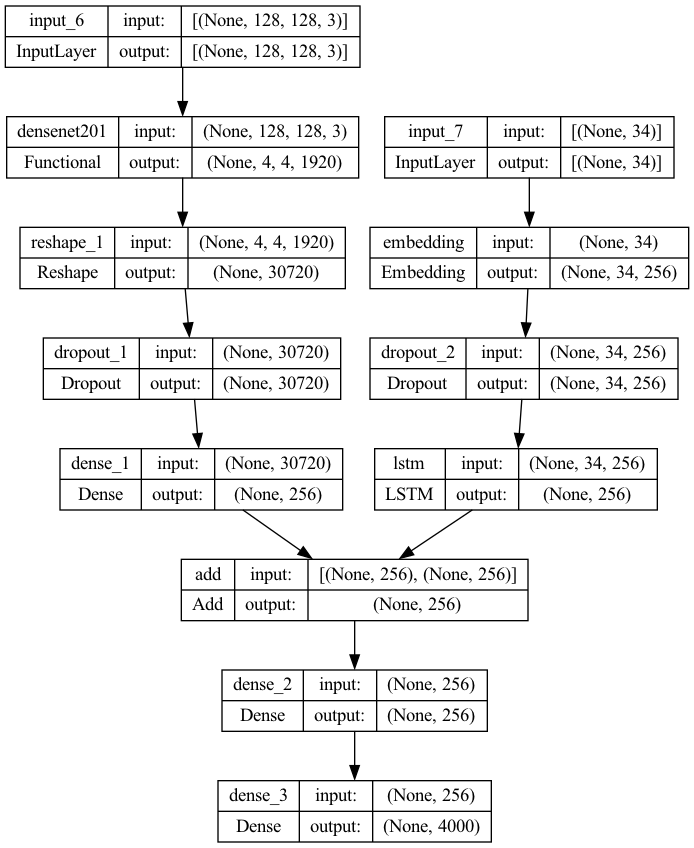

In [28]:
from tensorflow.keras.layers import Input, Reshape, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

# encoder model
# image feature layers
inputs0 = Input(shape=(128,128,3))
feature_extracted = image_model(inputs0)
reshaped_feature_extracted = Reshape((4*4*1920,), input_shape = (4,4,1920))(feature_extracted)
fe1 = Dropout(0.4)(reshaped_feature_extracted)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(34,))
se1 = Embedding(vocabulary_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocabulary_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs0, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

#### Creating batches for training data

In [102]:
dat = train_dataset.shuffle(1000).batch(32)
dat.element_spec

((TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 34), dtype=tf.int32, name=None)),
 TensorSpec(shape=(None, 4000), dtype=tf.float32, name=None))

In [104]:
for (inputs, predictions) in dat.take(6):
    (image, input_text) = inputs

print(image.shape)
print(input_text.shape)
print(predictions.shape)

(32, 128, 128, 3)
(32, 34)
(32, 4000)


#### Training the network and saving the model

In [50]:
model.fit(dat, epochs=1, verbose=1, callbacks = [history])

Training started.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
9597/9597 [==============================] - 8420s 876ms/step - loss: 4.3911


In [51]:
model.save("/Users/marcinzurek/Desktop/Aproksymacja/Projekt/model.h5")

In [34]:
model = tf.keras.models.load_model('/Users/marcinzurek/Desktop/Aproksymacja/Projekt/model.h5')

#### Checking the outcome

In [5]:
def describe_photo(photo_path, model_name):
    model = model_name
    img, image_path = load_image(photo_path)
    img = np.expand_dims(img, axis=0)
    input_text = '[START]'
    for i in range(34):
        text = tokenizer(input_text)
        text = tf.keras.utils.pad_sequences([text], maxlen = 34,padding = 'post')
        #text = np.squeeze(text)
        text = tf.convert_to_tensor(text)
        prediction = model.predict([img, text], verbose = 0)
        prediction = np.argmax(prediction)
        prediction = index_to_word(prediction)
        input_text = input_text + ' ' + prediction
        if prediction == '[END]':
            break
    return input_text

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


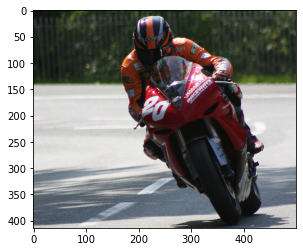

<tf.Tensor: shape=(), dtype=string, numpy=b'[START] man in red shirt is sitting on the beach [END]'>

In [43]:
photo1 = describe_photo('Flicker8k_Dataset/166321294_4a5e68535f.jpg', model)
img1 = image.imread('Flicker8k_Dataset/166321294_4a5e68535f.jpg')
pyplot.imshow(img1)
pyplot.show()
photo1

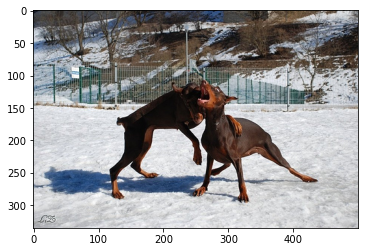

<tf.Tensor: shape=(), dtype=string, numpy=b'[START] two dogs are running through the grass [END]'>

In [44]:
photo2 = describe_photo('Flicker8k_Dataset/3385593926_d3e9c21170.jpg', model)
img2 = image.imread('Flicker8k_Dataset/3385593926_d3e9c21170.jpg')
pyplot.imshow(img2)
pyplot.show()
photo2

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


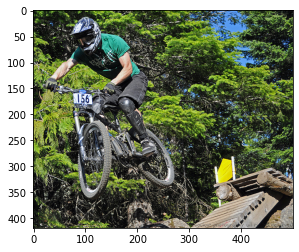

<tf.Tensor: shape=(), dtype=string, numpy=b'[START] man in red shirt is sitting on the beach [END]'>

In [99]:
photo3 = describe_photo('Flicker8k_Dataset/3696698390_989f1488e7.jpg', model)
img3 = image.imread('Flicker8k_Dataset/3696698390_989f1488e7.jpg')
pyplot.imshow(img3)
pyplot.show()
photo3

**Conclusion**: When testing these and multiple other sample images, I noticed that the model captures the first shape from the photo: man or dog and then generates always the same caption depending on the first word. This means that the model may be overfitted, especially with regards to text data.

#### Analysis of the loss function

Evaluation with test dataset

In [53]:
test_data = test_dataset.shuffle(1000).batch(32)

model.evaluate(test_data, verbose = 1, callbacks = [history])

Evaluation started.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1607/1607 [==============================] - 1250s 775ms/step - loss: 3.9660


3.966001033782959

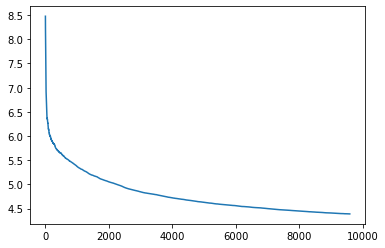

In [57]:
#Loss value for the training data - X axis represents batches (not epochs)
pyplot.plot(history.train_losses)

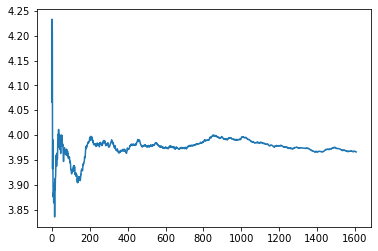

In [58]:
# Loss value for the test data - X axis represents batches (not epochs)
pyplot.plot(history.test_losses)

### 2nd approach to model architecture - no regularisation

To make sure that the model overfits the training data without a need to run numerous epochs of the training set, I deleted dropout layers which results in lower regularisation. My assumption is that the new model will perform even worse captions than the previous one.

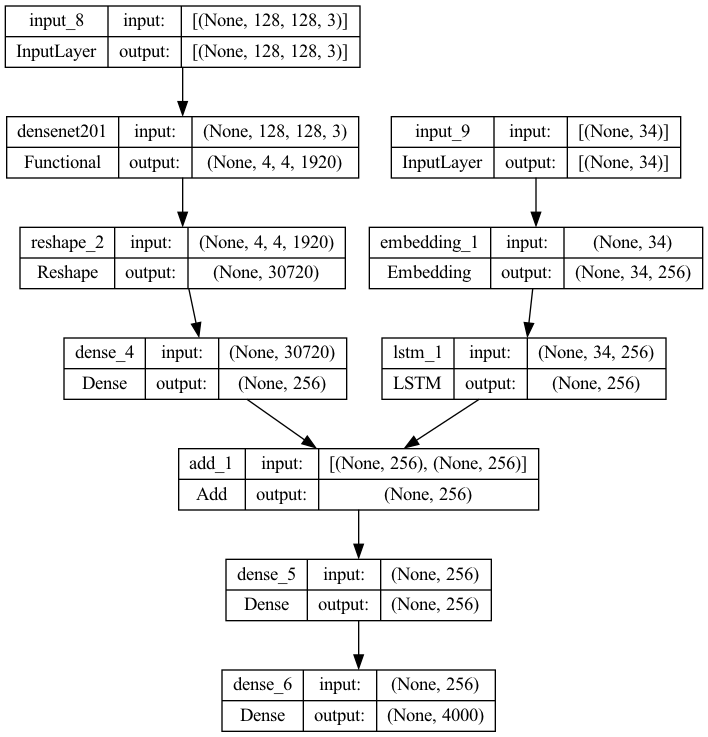

In [46]:
from tensorflow.keras.layers import Input, Reshape, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

# encoder model
# image feature layers
inputs0 = Input(shape=(128,128,3))
feature_extracted = image_model(inputs0)
reshaped_feature_extracted = Reshape((4*4*1920,), input_shape = (4,4,1920))(feature_extracted)
fe2 = Dense(256, activation='relu')(reshaped_feature_extracted)
# sequence feature layers
inputs2 = Input(shape=(34,))
se1 = Embedding(vocabulary_size, 256, mask_zero=True)(inputs2)
se3 = LSTM(256)(se1)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocabulary_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs0, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [106]:
history_dropout = LossHistory()
model.fit(dat, epochs=1, verbose=1, callbacks = [history_dropout])

Training started.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
9597/9597 [==============================] - 10077s 1s/step - loss: 4.3560


In [107]:
model.save("/Users/marcinzurek/Desktop/Aproksymacja/Projekt/model_nodropout.h5")

In [47]:
model_nodropout = tf.keras.models.load_model('/Users/marcinzurek/Desktop/Aproksymacja/Projekt/model_nodropout.h5')

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


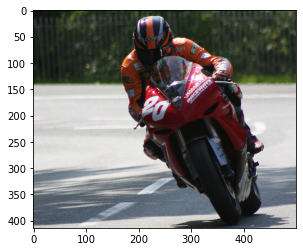

<tf.Tensor: shape=(), dtype=string, numpy=b'[START] man in red shirt and black shirt is sitting on the beach [END]'>

In [48]:
photo1 = describe_photo('Flicker8k_Dataset/166321294_4a5e68535f.jpg', model_nodropout)
img1 = image.imread('Flicker8k_Dataset/166321294_4a5e68535f.jpg')
pyplot.imshow(img1)
pyplot.show()
photo1

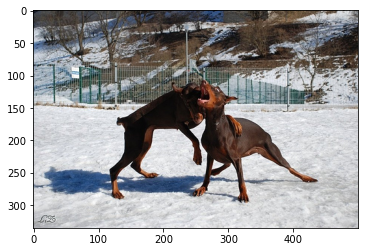

<tf.Tensor: shape=(), dtype=string, numpy=b'[START] man in red shirt and black shirt is sitting on the beach [END]'>

In [49]:
photo2 = describe_photo('Flicker8k_Dataset/3385593926_d3e9c21170.jpg', model_nodropout)
img2 = image.imread('Flicker8k_Dataset/3385593926_d3e9c21170.jpg')
pyplot.imshow(img2)
pyplot.show()
photo2

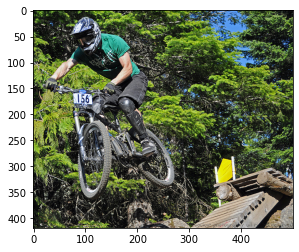

<tf.Tensor: shape=(), dtype=string, numpy=b'[START] man in red shirt and black shirt is sitting on the beach [END]'>

In [95]:
photo3 = describe_photo('Flicker8k_Dataset/3696698390_989f1488e7.jpg', model_nodropout)
img3 = image.imread('Flicker8k_Dataset/3696698390_989f1488e7.jpg')
pyplot.imshow(img3)
pyplot.show()
photo3

In [80]:
test_data = test_dataset.shuffle(1000).batch(32)
history_dropout = LossHistory()
model_nodropout.evaluate(test_data, verbose = 1, callbacks = [history_dropout])

Evaluation started.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1607/1607 [==============================] - 1481s 918ms/step - loss: 3.9695


3.969482660293579

**Conclusion**: The assumptions were correct, now the model does not capture the information from pictures and often predicts the same caption. So we need to keep the dropout regularisation but we need to extract more information from the pictures. I will do a normalisation of the outputs so that the weights representing the textual information are as strongly represented as the weights representing image data.

### 3rd approach to model architecture - additional BatchNorm layer

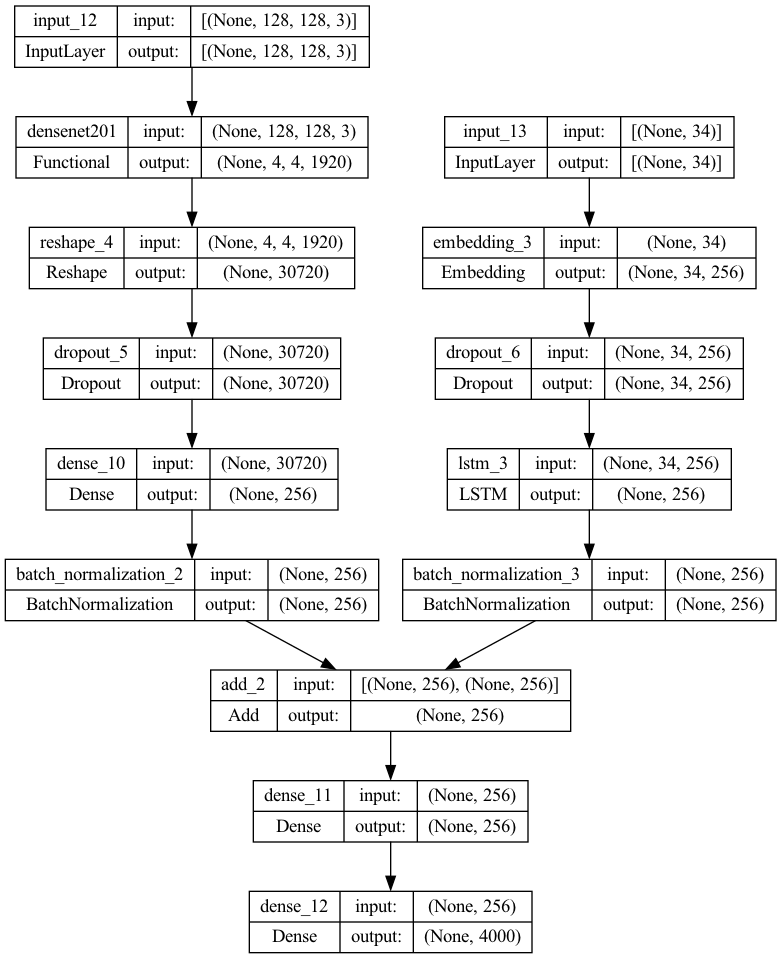

In [60]:
from tensorflow.keras.layers import Input, Reshape, Dense, LSTM, Embedding, Dropout, add, BatchNormalization, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

# encoder model
# image feature layers
inputs0 = Input(shape=(128,128,3))
feature_extracted = image_model(inputs0)
reshaped_feature_extracted = Reshape((4*4*1920,), input_shape = (4,4,1920))(feature_extracted)
fe1 = Dropout(0.4)(reshaped_feature_extracted)
fe2 = Dense(256, activation='relu')(fe1)
fe3 = BatchNormalization()(fe2)

# sequence feature layers
inputs2 = Input(shape=(34,))
se1 = Embedding(vocabulary_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)
se4 = BatchNormalization()(se3)

# decoder model
decoder1 = add([fe3, se4])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocabulary_size, activation='softmax')(decoder2)

model3 = Model(inputs=[inputs0, inputs2], outputs=outputs)
model3.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model3, show_shapes=True)

In [125]:
history3 = LossHistory()
dat3 = train_dataset.shuffle(1000).batch(32)
model3.fit(dat3, epochs=1, verbose=1, callbacks = [history3])

Training started.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
9597/9597 [==============================] - 11062s 1s/step - loss: 4.1321


In [126]:
model3.save("/Users/marcinzurek/Desktop/Aproksymacja/Projekt/model_batchnorm_add.h5")

In [63]:
model_batchnorm_add = tf.keras.models.load_model('/Users/marcinzurek/Desktop/Aproksymacja/Projekt/model_batchnorm_add.h5')

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


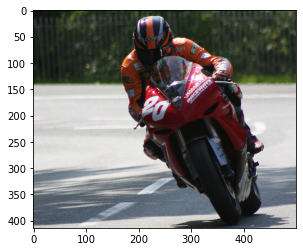

<tf.Tensor: shape=(), dtype=string, numpy=b'[START] man in red helmet is riding bike on dirt track [END]'>

In [64]:
photo1 = describe_photo('Flicker8k_Dataset/166321294_4a5e68535f.jpg', model_batchnorm_add)
img1 = image.imread('Flicker8k_Dataset/166321294_4a5e68535f.jpg')
pyplot.imshow(img1)
pyplot.show()
photo1

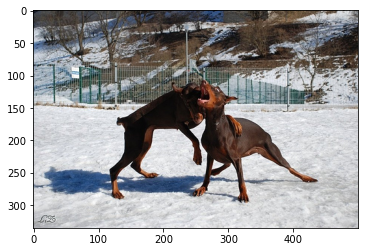

<tf.Tensor: shape=(), dtype=string, numpy=b'[START] two dogs are running through the grass [END]'>

In [65]:
photo2 = describe_photo('Flicker8k_Dataset/3385593926_d3e9c21170.jpg', model_batchnorm_add)
img2 = image.imread('Flicker8k_Dataset/3385593926_d3e9c21170.jpg')
pyplot.imshow(img2)
pyplot.show()
photo2

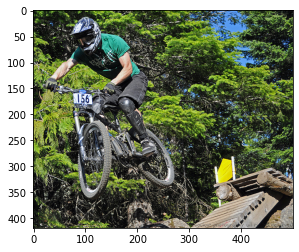

<tf.Tensor: shape=(), dtype=string, numpy=b'[START] man in blue shirt is riding bicycle on dirt path [END]'>

In [94]:
photo3 = describe_photo('Flicker8k_Dataset/3696698390_989f1488e7.jpg', model_batchnorm_add)
img3 = image.imread('Flicker8k_Dataset/3696698390_989f1488e7.jpg')
pyplot.imshow(img3)
pyplot.show()
photo3

In [81]:
test_data = test_dataset.shuffle(1000).batch(32)
history3 = LossHistory()
model_batchnorm_add.evaluate(test_data, verbose = 1, callbacks = [history3])

Evaluation started.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1607/1607 [==============================] - 1496s 928ms/step - loss: 4.0100


4.009972095489502

This model is better than previous models (based on my subjective opinion) - but it is worth trying to concatenate the text and img vectors instead of adding them in order to separately capture text and image information.

### 4th approach to model architecture - BatchNorm layer and Concatenation

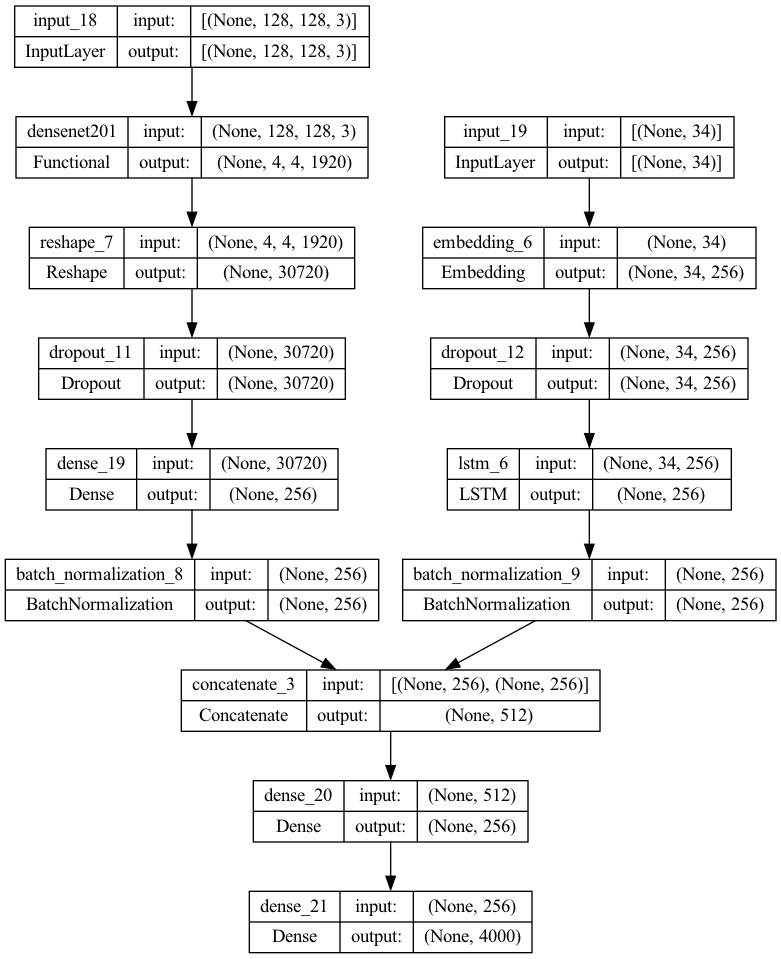

In [69]:
from tensorflow.keras.layers import Input, Reshape, Dense, LSTM, Embedding, Dropout, add, BatchNormalization, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

# encoder model
# image feature layers
inputs0 = Input(shape=(128,128,3))
feature_extracted = image_model(inputs0)
reshaped_feature_extracted = Reshape((4*4*1920,), input_shape = (4,4,1920))(feature_extracted)
fe1 = Dropout(0.4)(reshaped_feature_extracted)
fe2 = Dense(256, activation='relu')(fe1)
fe3 = BatchNormalization()(fe2)

# sequence feature layers
inputs2 = Input(shape=(34,))
se1 = Embedding(vocabulary_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)
se4 = BatchNormalization()(se3)

# decoder model
decoder1 = Concatenate()([fe3, se4])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocabulary_size, activation='softmax')(decoder2)

model2 = Model(inputs=[inputs0, inputs2], outputs=outputs)
model2.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model2, show_shapes=True)

In [70]:
history2 = LossHistory()
dat2 = train_dataset.shuffle(1000).batch(32)
model2.fit(dat2, epochs=1, verbose=1, callbacks = [history2])

Training started.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
9597/9597 [==============================] - 8745s 910ms/step - loss: 4.1331


In [71]:
model2.save("/Users/marcinzurek/Desktop/Aproksymacja/Projekt/model_batchnorm.h5")

In [32]:
model_batchnorm = tf.keras.models.load_model('/Users/marcinzurek/Desktop/Aproksymacja/Projekt/model_batchnorm.h5')

The model is created and trained with one epoch. I will now check how some predictions work.

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


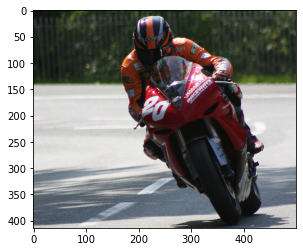

<tf.Tensor: shape=(), dtype=string, numpy=b'[START] man in red helmet is riding motorcycle [END]'>

In [73]:
photo1 = describe_photo('Flicker8k_Dataset/166321294_4a5e68535f.jpg', model_batchnorm)
img1 = image.imread('Flicker8k_Dataset/166321294_4a5e68535f.jpg')
pyplot.imshow(img1)
pyplot.show()
photo1

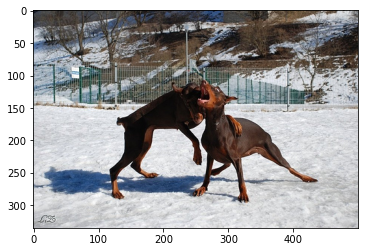

<tf.Tensor: shape=(), dtype=string, numpy=b'[START] two dogs are running on the beach [END]'>

In [74]:
photo2 = describe_photo('Flicker8k_Dataset/3385593926_d3e9c21170.jpg', model_batchnorm)
img2 = image.imread('Flicker8k_Dataset/3385593926_d3e9c21170.jpg')
pyplot.imshow(img2)
pyplot.show()
photo2

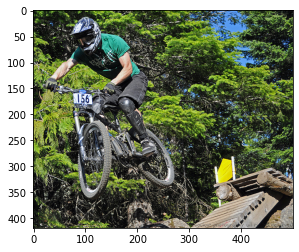

<tf.Tensor: shape=(), dtype=string, numpy=b'[START] man in red shirt is riding bicycle on dirt track [END]'>

In [92]:
photo3 = describe_photo('Flicker8k_Dataset/3696698390_989f1488e7.jpg', model_batchnorm)
img3 = image.imread('Flicker8k_Dataset/3696698390_989f1488e7.jpg')
pyplot.imshow(img3)
pyplot.show()
photo3

In [76]:
test_data = test_dataset.shuffle(1000).batch(32)

model_batchnorm.evaluate(test_data, verbose = 1, callbacks = [history2])

Evaluation started.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1607/1607 [==============================] - 1370s 851ms/step - loss: 4.3902


4.390191078186035

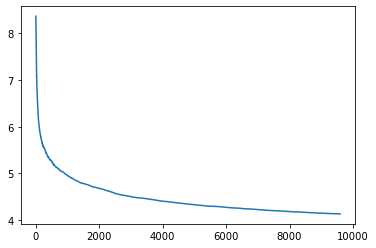

In [77]:
#Loss value for the training data - X axis represents batches (not epochs)
pyplot.plot(history2.train_losses)

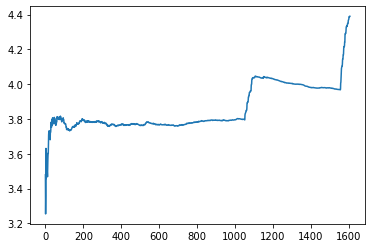

In [78]:
# Loss value for the test data - X axis represents batches (not epochs)
pyplot.plot(history2.test_losses)

### 5th approach to model architecture - BatchNorm layer and Concatenation, 64 batch size

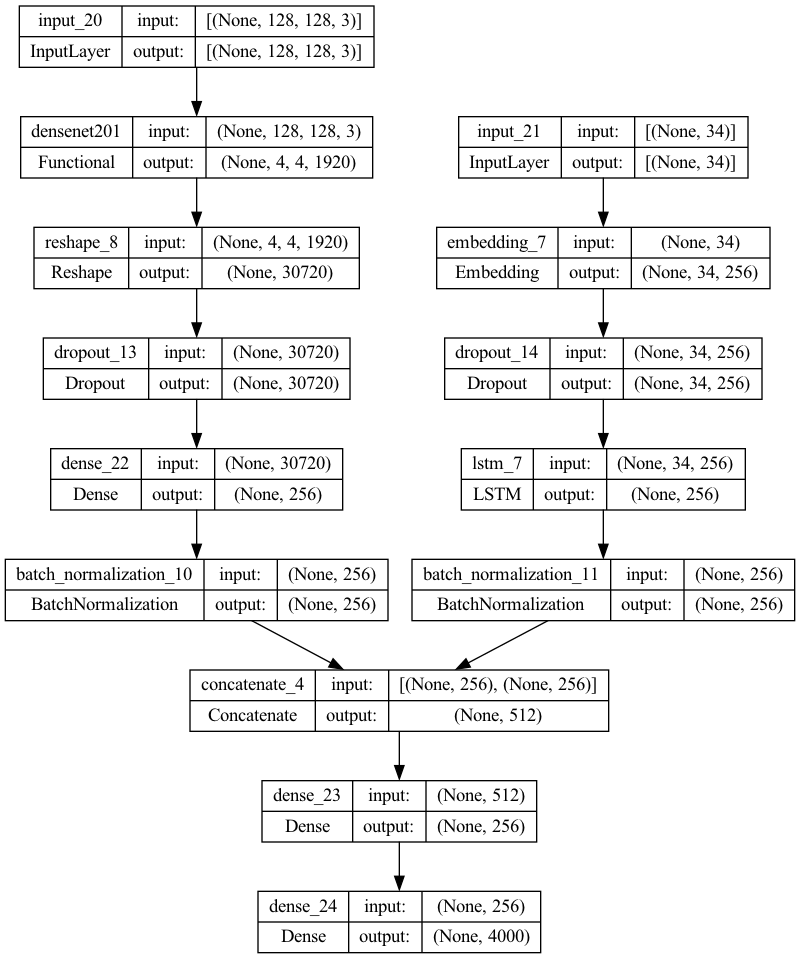

In [82]:
from tensorflow.keras.layers import Input, Reshape, Dense, LSTM, Embedding, Dropout, add, BatchNormalization, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

# encoder model
# image feature layers
inputs0 = Input(shape=(128,128,3))
feature_extracted = image_model(inputs0)
reshaped_feature_extracted = Reshape((4*4*1920,), input_shape = (4,4,1920))(feature_extracted)
fe1 = Dropout(0.4)(reshaped_feature_extracted)
fe2 = Dense(256, activation='relu')(fe1)
fe3 = BatchNormalization()(fe2)

# sequence feature layers
inputs2 = Input(shape=(34,))
se1 = Embedding(vocabulary_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)
se4 = BatchNormalization()(se3)

# decoder model
decoder1 = Concatenate()([fe3, se4])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocabulary_size, activation='softmax')(decoder2)

model2_64 = Model(inputs=[inputs0, inputs2], outputs=outputs)
model2_64.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model2_64, show_shapes=True)

In [83]:
history2_64 = LossHistory()
dat2_64 = train_dataset.shuffle(1000).batch(64) #this time batch size is 64
model2_64.fit(dat2_64, epochs=1, verbose=1, callbacks = [history2_64])

Training started.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
4799/4799 [==============================] - 8160s 2s/step - loss: 3.9976


In [84]:
model2_64.save("/Users/marcinzurek/Desktop/Aproksymacja/Projekt/model_batchnorm64.h5")

In [85]:
model_batchnorm_64 = tf.keras.models.load_model('/Users/marcinzurek/Desktop/Aproksymacja/Projekt/model_batchnorm64.h5')

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


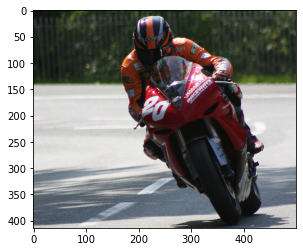

<tf.Tensor: shape=(), dtype=string, numpy=b'[START] man in helmet riding on dirt bike [END]'>

In [86]:
photo1 = describe_photo('Flicker8k_Dataset/166321294_4a5e68535f.jpg', model_batchnorm_64)
img1 = image.imread('Flicker8k_Dataset/166321294_4a5e68535f.jpg')
pyplot.imshow(img1)
pyplot.show()
photo1

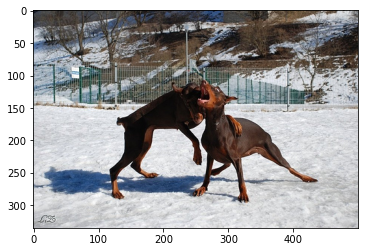

<tf.Tensor: shape=(), dtype=string, numpy=b'[START] two dogs are running through the grass [END]'>

In [87]:
photo2 = describe_photo('Flicker8k_Dataset/3385593926_d3e9c21170.jpg', model_batchnorm_64)
img2 = image.imread('Flicker8k_Dataset/3385593926_d3e9c21170.jpg')
pyplot.imshow(img2)
pyplot.show()
photo2

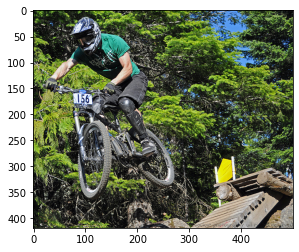

<tf.Tensor: shape=(), dtype=string, numpy=b'[START] man in blue shirt and helmet is riding bicycle on dirt bike [END]'>

In [93]:
photo3 = describe_photo('Flicker8k_Dataset/3696698390_989f1488e7.jpg', model_batchnorm_64)
img3 = image.imread('Flicker8k_Dataset/3696698390_989f1488e7.jpg')
pyplot.imshow(img3)
pyplot.show()
photo3

In [89]:
test_data = test_dataset.shuffle(1000).batch(32)

model_batchnorm_64.evaluate(test_data, verbose = 1, callbacks = [history2_64])

Evaluation started.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1607/1607 [==============================] - 1431s 889ms/step - loss: 3.6526


3.6525521278381348

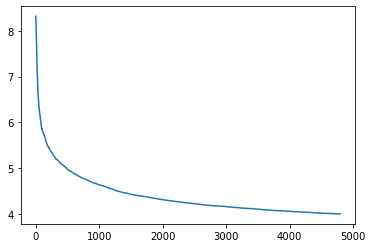

In [90]:
#Loss value for the training data - X axis represents batches (not epochs)
pyplot.plot(history2_64.train_losses)

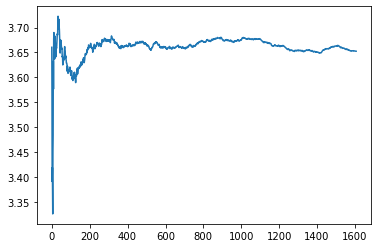

In [91]:
# Loss value for the test data - X axis represents batches (not epochs)
pyplot.plot(history2_64.test_losses)

### Summary
The model with `Dropout`, `BatchNormalization` and `Concatenate` layers and batch of 64 seems to be the best from the models that were checked. Based on subjective assessment, I managed to prevent overfitting - the generated captions make sense. Also the loss function on the test set is the lowest. Obviously the project requires further analysis and hyperparameter tuning. However I am unable to do it because of limited computing power - running one epoch of training dataset takes 2.5 hours.